# Synthetic Sonic Log Generation -- Yanxiang Yu 

* __Author__: _Yanxiang Yu_
* __Date__: February 26th, 2020


- <a>1. Introduction: Synthetic Sonic Curves Generation </a>
    - <a>1.1. Background</a>
    - <a>1.2. Problem Statement</a>
    - <a>1.3. Data Description</a>
    - <a>1.4. Evaluation Metric</a>
- <a>2. Imports</a>
- <a>3. Read in Data</a>
- <a>4. Glimpse of Data</a>
- <a>5. Exploratory Data Analysis</a>
- <a>6. Build Machine Models</a>
- <a>7. Prediction</a>
- <a>8. Summary</a>

<a></a>

## <a>1. Introduction: Synthetic Sonic Curves Generation</a>


### <a>1.1. Background</a>
Well logs are interpreted/processed to estimate the in-situ petrophysical and geomechanical properties, which is essential for subsurface characterization. Various types of logs exist, and each provides distinct information about subsurface properties. Certain well logs, like gamma ray (GR), resistivity, density, and neutron logs, are considered as “easy-to-acquire” conventional well logs that are run in most of the wells. Other well logs, like nuclear magnetic resonance, dielectric dispersion, elemental spectroscopy, and sometimes sonic logs, are only run in limited number of wells.

Sonic travel-time logs contain critical geomechanical information for subsurface characterization around the wellbore. Often, sonic logs are required to complete the well-seismic tie workflow or geomechanical properties prediction. When sonic logs are absent in a well or an interval, a common practice is to synthesize them based on its neighboring wells that have sonic logs. This is referred to as sonic log synthesis or pseudo sonic log generation.


### <a>1.2. Problem Statement</a>
Compressional travel-time (DTC) and shear travel-time (DTS) logs are not acquired in all the wells drilled in a field due to financial or operational constraints. Under such circumstances, machine learning techniques can be used to predict DTC and DTS logs to improve subsurface characterization. The goal of the “SPWLA’s 1st Petrophysical Data-Driven Analytics Contest” is to develop data-driven models by processing “easy-to-acquire” conventional logs from Well #1, and use the data-driven models to generate synthetic compressional and shear travel-time logs (DTC and DTS, respectively) in Well #2. A robust data-driven model for the desired sonic-log synthesis will result in low prediction errors, which can be quantified in terms of Root Mean Squared Error by comparing the synthesized and the original DTC and DTS logs.

You are provided with two datasets: train.csv and test.csv. You need to build a generalizable data-driven models using train dataset. Following that, you will deploy the newly developed data-driven models on test dataset to predict DTS and DTC logs. The data-driven model should use feature sets derived from the following 7 logs: Caliper, Neutron, Gamma Ray, Deep Resistivity, Medium Resistivity, Photo-electric factor and density. The data-driven model should synthesize two target logs: DTC and DTS logs.

The predicted values should be in the same format as sample_submission.csv, and submit together with your notebook for evaluation. 

### <a>1.3. Data Decription</a>
#### Files
&gt; #### train.csv
All the values equals to -999 are marked as missing values.
- CAL - Caliper, unit in Inch,  
- CNC - Neutron, unit in dec 
- GR - Gamma Ray, unit in API
- HRD - Deep Resisitivity, unit in Ohm per meter,
- HRM - Medium Resistivity, unit in Ohm per meter,
- PE - Photo-electric Factor, unit in Barn,
- ZDEN - Density, unit in Gram per cubit meter, 
- DTC - Compressional Travel-time, unit in nanosecond per foot,
- DTS - Shear Travel-time, unit in nanosecond per foot,


&gt; #### test.csv
The test data has all features that you used in the train dataset, except the two sonic curves DTC and DTS.

&gt; ####  sample_submission.csv
A valid sample submission.
<p><font style="">
</font></p>

### <a>1.4. Evaluation Metric</a>
We will be evaluated by the metirc `Root Mean Squared Error`.

The RMSE is calculated as:

$ ϵ=∑_i \sqrt{ ∑_n (y_p - y_t)^2 /n } $

Where:
- y_p is the predicted curve for DTC and DTS
- y_t is the true value for evaluation.

DTC and DTS are in the same weight during the evaluation 

Understanding and optimizing your predictions for this evaluation metric is paramount for this compeition.

## <a>2. Imports</a>

<a>Top</a>

In [1]:
# import libraries
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
# import sklearn libararies
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression 
from sklearn.neural_network import MLPRegressor

## <a>3. Read Data</a>

<a>Top</a>

In [2]:
df1 = pd.read_csv('train.csv')


## <a>4. Glimps Data</a>

<a>Top</a>

In [3]:
df1.describe()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS
count,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000
mean,-8.394576,-23.692615,38.959845,3.977690,1.547299,-17.446739,-20.229982,-54.891703,-9.737567
std,129.970219,157.142679,108.504554,365.112753,456.908969,149.083136,148.809506,372.858812,440.314119
min,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000
25%,8.058350,0.122800,17.248750,0.717700,0.712050,0.053100,2.226700,66.304350,118.534350
50%,8.625000,0.193600,36.821800,1.623000,1.628100,4.941500,2.432200,78.355100,137.689300
75%,9.048850,0.337150,58.346150,3.158300,3.280600,7.856650,2.551350,107.022500,182.973150
max,21.064200,3490.158200,1470.253400,10000.000000,60467.761700,28.106400,3.259700,155.980300,487.438400


## <a>5. Exploratory Data Analysis</a>

<a>Top</a>

Exploratory Data Analysis (EDA) is an open-ended process where we calculate statistics and make figures to find trends, missing values, outliers, anomalies, patterns, or relationships within the data. 

## Try to explore null values

In [30]:
df1['CAL'].value_counts()

 8.6250      3558
 8.5781      3163
 8.5469      1257
 8.6719      1174
-999.0000     510
             ... 
 8.8513         1
 9.4825         1
 8.7864         1
 6.7320         1
 6.5000         1
Name: CAL, Length: 13612, dtype: int64

In [31]:
df1['CNC'].value_counts()

-999.0000    735
 0.1266       22
 0.1215       22
 0.1425       21
 0.1292       21
            ... 
 0.0226        1
 0.4900        1
 0.3194        1
 0.4646        1
 11.6302       1
Name: CNC, Length: 5994, dtype: int64

In [33]:
df1['GR'].value_counts()

-999.0000    254
 0.0000       22
 33.8944       3
 33.6465       3
 7.6060        3
            ... 
 54.8715       1
 62.2157       1
 38.1285       1
 56.7101       1
 17.5599       1
Name: GR, Length: 29341, dtype: int64

In [34]:
df1['HRD'].value_counts()

-999.0000      385
 10000.0000     26
 3.1748          9
 2.2883          9
 2.4671          9
              ... 
 0.5936          1
 4.1526          1
 1.7219          1
 1.1318          1
 11.6552         1
Name: HRD, Length: 19386, dtype: int64

In [35]:
df1['HRM'].value_counts()

-999.0000      385
 10000.0000     12
 3.0859         10
 0.3900          9
 0.2920          8
              ... 
 2.0824          1
 5.8880          1
 6.9076          1
 5.6824          1
 2.5000          1
Name: HRM, Length: 20649, dtype: int64

In [36]:
df1['PE'].value_counts()

-999.0000    679
 0.0486       86
 0.0493       70
 0.0497       69
 0.0465       67
            ... 
 5.6313        1
 8.4246        1
 5.8011        1
 6.7657        1
 4.5000        1
Name: PE, Length: 18138, dtype: int64

In [37]:
df1['ZDEN'].value_counts()

-999.0000    681
 2.5699       23
 2.5602       22
 2.5641       19
 2.5590       18
            ... 
 2.0667        1
 2.6691        1
 2.9266        1
 2.0178        1
 2.0746        1
Name: ZDEN, Length: 6520, dtype: int64

In [4]:
df1[df1['CAL'].isna()]

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS


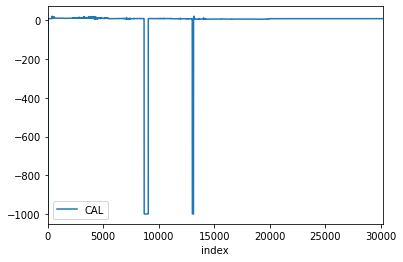

In [5]:
df1.reset_index().plot(x='index',y ='CAL')

In [6]:
df1[df1['CNC'].isna()]

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS


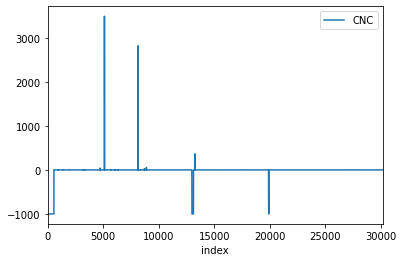

In [7]:
df1.reset_index().plot(x='index',y ='CNC')

In [8]:
df1[df1['GR'].isna()]

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS


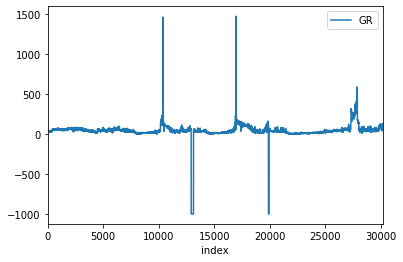

In [9]:
df1.reset_index().plot(x='index',y ='GR')

In [10]:
df1[df1['HRD'].isna()]

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS


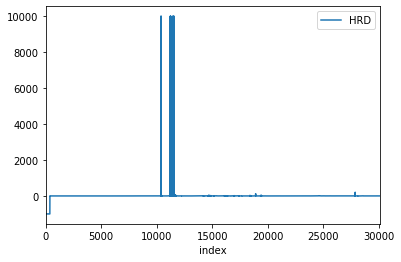

In [11]:
df1.reset_index().plot(x='index',y ='HRD')

In [12]:
df1[df1['HRM'].isna()]

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS


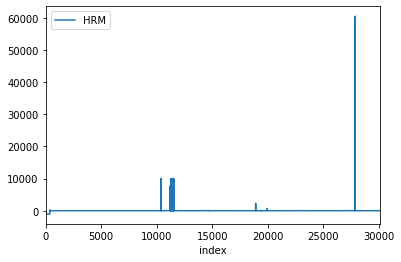

In [13]:
df1.reset_index().plot(x='index',y ='HRM')

In [14]:
df1[df1['PE'].isna()]

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS


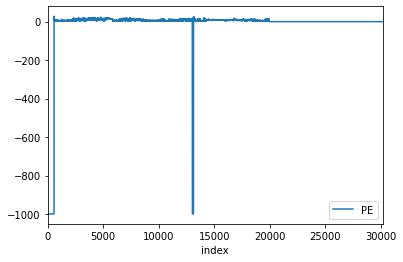

In [15]:
df1.reset_index().plot(x='index',y ='PE')

In [16]:
df1[df1['ZDEN'].isna()]

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS


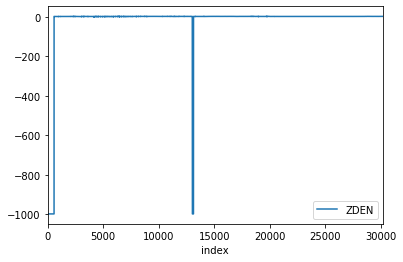

In [17]:
df1.reset_index().plot(x='index',y ='ZDEN')

In [18]:
df1[df1['DTC'].isna()]

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS


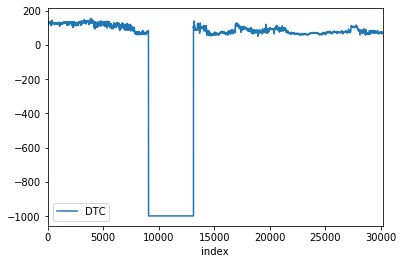

In [19]:
df1.reset_index().plot(x='index',y ='DTC')

In [20]:
df1[df1['DTS'].isna()]

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS


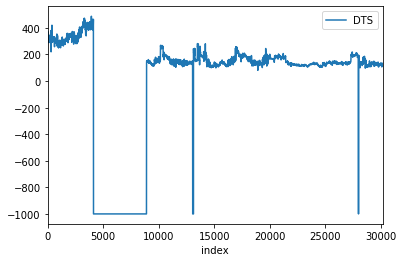

In [21]:
df1.reset_index().plot(x='index',y ='DTS')

In [22]:
df1['DTS'].value_counts()

-999.0000    4865
 190.2344       6
 137.4269       3
 125.3047       3
 132.5795       3
             ... 
 123.6564       1
 176.8614       1
 113.4098       1
 120.8183       1
 147.1446       1
Name: DTS, Length: 24972, dtype: int64

In [23]:
df1['DTC'].value_counts()

-999.0000    4054
 77.6880        4
 74.4197        3
 67.8852        3
 74.2393        3
             ... 
 78.8390        1
 109.3310       1
 75.9471        1
 76.9233        1
 80.0000        1
Name: DTC, Length: 25584, dtype: int64

In [4]:
df_original = df1.copy()

In [5]:
df_original['DTC']

0        128.0737
1        127.8347
2        127.2307
3        126.2917
4        125.3985
           ...   
30138     74.2133
30139     74.3503
30140     74.4752
30141     74.5917
30142     74.7082
Name: DTC, Length: 30143, dtype: float64

### DTC and DTS's missing values are non-overlapping. So first, drop DTC NA value, then use DTS and other 7 logs for prediction. Then drop DTS NA value, then use DTC and other 7 logs for prediction.

In [6]:
df_original.head()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS
0,-999.0,-999.0,41.4699,-999.0,-999.0,-999.0,-999.0,128.0737,319.0654
1,-999.0,-999.0,42.5053,-999.0,-999.0,-999.0,-999.0,127.8347,318.7825
2,-999.0,-999.0,43.1548,-999.0,-999.0,-999.0,-999.0,127.2307,317.3323
3,-999.0,-999.0,43.2410,-999.0,-999.0,-999.0,-999.0,126.2917,313.6486
4,-999.0,-999.0,40.3218,-999.0,-999.0,-999.0,-999.0,125.3985,307.8903


In [7]:
#remove all rows that contains missing value
df_original['DTC'].replace(['-999', -999], np.nan, inplace=True)
df_original['DTS'].replace(['-999', -999], np.nan, inplace=True)
df_original['CAL'].replace(['-999', -999], np.nan, inplace=True)
df_original['CNC'].replace(['-999', -999], np.nan, inplace=True)
df_original['PE'].replace(['-999', -999], np.nan, inplace=True)
df_original['ZDEN'].replace(['-999', -999], np.nan, inplace=True)
df_original['HRD'].replace(['-999', -999], np.nan, inplace=True)
df_original['HRM'].replace(['-999', -999], np.nan, inplace=True)

### check the number of elements have all null elements for 7 logs. These are unable to be predicted

In [8]:
df_original[(df_original['CNC'].isnull()) & (df_original['HRD'].isnull()) &(df_original['HRM'].isnull()) & (df_original['PE'].isnull()) & (df_original['ZDEN'].isnull())]

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS
0,NaN,NaN,41.4699,NaN,NaN,NaN,NaN,128.0737,319.0654
1,NaN,NaN,42.5053,NaN,NaN,NaN,NaN,127.8347,318.7825
2,NaN,NaN,43.1548,NaN,NaN,NaN,NaN,127.2307,317.3323
3,NaN,NaN,43.2410,NaN,NaN,NaN,NaN,126.2917,313.6486
4,NaN,NaN,40.3218,NaN,NaN,NaN,NaN,125.3985,307.8903
...,...,...,...,...,...,...,...,...,...
380,9.1165,NaN,33.2890,NaN,NaN,NaN,NaN,136.3456,345.1888
381,9.3658,NaN,32.6672,NaN,NaN,NaN,NaN,140.4026,368.6186
382,9.4039,NaN,32.1370,NaN,NaN,NaN,NaN,143.3167,392.9880
383,9.3717,NaN,30.2842,NaN,NaN,NaN,NaN,144.8578,410.5328


In [9]:
df_original['DTS'].value_counts()

190.2344    6
137.4269    3
125.3047    3
132.5795    3
133.4251    3
           ..
176.8614    1
113.4098    1
120.8183    1
177.0725    1
147.1446    1
Name: DTS, Length: 24971, dtype: int64

In [10]:
df_original['DTC'].value_counts()

77.6880     4
74.4197     3
67.9568     3
73.4193     3
67.8852     3
           ..
109.3310    1
75.9471     1
76.9233     1
69.6604     1
80.0000     1
Name: DTC, Length: 25583, dtype: int64

### First use fill DTC null values

In [11]:
df_DTC_not_null = df_original[~df_original['DTC'].isnull()] 

In [12]:
len(df_DTC_not_null)

26089

In [13]:
df_DTC_not_null.head()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS
0,NaN,NaN,41.4699,NaN,NaN,NaN,NaN,128.0737,319.0654
1,NaN,NaN,42.5053,NaN,NaN,NaN,NaN,127.8347,318.7825
2,NaN,NaN,43.1548,NaN,NaN,NaN,NaN,127.2307,317.3323
3,NaN,NaN,43.2410,NaN,NaN,NaN,NaN,126.2917,313.6486
4,NaN,NaN,40.3218,NaN,NaN,NaN,NaN,125.3985,307.8903


In [51]:
df_DTC_null = df_original[df_original['DTC'].isnull()] 
df_DTC_null.head()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS
9071,9.2283,0.1511,19.6345,2.0004,2.0025,4.9002,2.4999,NaN,154.5933
9072,9.2053,0.1462,18.0560,2.0411,2.0438,5.0943,2.5163,NaN,154.2602
9073,9.1987,0.1500,16.7997,2.0366,2.0418,4.8517,2.4698,NaN,153.7306
9074,9.2158,0.1484,16.3179,1.9926,2.0000,4.7805,2.5137,NaN,153.1662
9075,9.2219,0.1549,14.8773,1.9588,1.9652,4.7819,2.4858,NaN,152.5901


In [50]:
# seperate the features and targets
df_DTC_array = np.array(df_DTC_not_null)


y_trainwell1 = df_DTC_array[:,-2:-1]
x_trainwell1 = df_DTC_array[:,:-2]

# standize the matrix for training data
scaler = StandardScaler()
x_trainwell1 = scaler.fit_transform(x_trainwell1)

In [78]:
# seperate the features and targets
df_DTC_null = np.array(df_DTC_null)


y_testwell1 = df_DTC_null[:,-2:-1]
x_testwell1 = df_DTC_null[:,:-2]

# standize the matrix for training data
x_testwell1 = scaler.transform(x_testwell1)

In [52]:
x_trainwell1

array([[        nan,         nan, -0.05549272, ...,         nan,
                nan,         nan],
       [        nan,         nan, -0.03965558, ...,         nan,
                nan,         nan],
       [        nan,         nan, -0.02972105, ...,         nan,
                nan,         nan],
       ...,
       [ 0.01470894, -0.0176201 ,  1.17710078, ..., -0.00663317,
        -0.98421764,  1.13520249],
       [ 0.0105307 , -0.01771113,  1.15564708, ..., -0.00655635,
        -0.98439704,  1.13029079],
       [ 0.0105307 , -0.0177172 ,  1.15373818, ..., -0.00654019,
        -0.98459637,  1.12832612]])

In [79]:
x_testwell1

array([[ 3.08578260e-01, -1.84181407e-02, -3.89479673e-01, ...,
        -7.87608749e-03, -1.88318636e-02,  5.60534215e-01],
       [ 2.96257818e-01, -1.85668252e-02, -4.13623880e-01, ...,
        -7.76668326e-03,  1.98585162e-02,  6.41086007e-01],
       [ 2.92722387e-01, -1.84515188e-02, -4.32839824e-01, ...,
        -7.77198129e-03, -2.84994752e-02,  4.12692206e-01],
       ...,
       [            nan,             nan, -1.59701715e+01, ...,
        -1.06988757e-02,             nan,             nan],
       [            nan,             nan, -1.59701715e+01, ...,
        -1.06641736e-02,             nan,             nan],
       [            nan,             nan, -1.59701715e+01, ...,
        -1.06016569e-02,             nan,             nan]])

In [53]:
np.shape(y_trainwell1)

(26089, 1)

In [54]:
# train test split
# please remember to use random_state for all randomization steps, this will ensure we get the same results 
# as yours during the validation phase. 
X_train, X_test, y_train, y_test = train_test_split(x_trainwell1, y_trainwell1, test_size=0.2, random_state=100)

In [57]:

import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn import model_selection

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, SGDRegressor
# model evaluation
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error

### XGBOOST

In [64]:
#params={'objective':'reg:squarederror','colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 120, 'subsample': 0.7}
params={'objective':'reg:squarederror', 'colsample_bytree': 0.9, 'gamma': 0.6, 'learning_rate': 0.05, 'max_depth': 17, 'n_estimators': 180, 'subsample': 0.9}
xgbr = xgb.XGBRegressor(**params)
xgbr.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, gamma=0.6,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=17, min_child_weight=1, missing=None, n_estimators=180,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.9, verbosity=1)

In [68]:
cv_results = model_selection.cross_val_score(xgbr, X_train, y_train, cv=5, scoring='r2', verbose=3)
print('Best score: {}'.format(cv_results.max()))
print('Mean score: {}'.format(cv_results.mean()))
print('std score: {}'.format(cv_results.std()))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] .................................... , score=0.981, total=  10.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.6s remaining:    0.0s


[CV] .................................... , score=0.980, total=  10.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   20.9s remaining:    0.0s


[CV] .................................... , score=0.982, total=  10.1s
[CV]  ................................................................
[CV] .................................... , score=0.981, total=  10.2s
[CV]  ................................................................
[CV] .................................... , score=0.984, total=  10.9s
Best score: 0.9837313895626383
Mean score: 0.9815686191779669
std score: 0.0011662143542124615


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   52.1s finished


In [73]:
def result_plot(y_predict, y_real=y_trainwell1):
    # check the accuracy of predicted data and plot the result
    print('Root Mean Square Error is:', '{:.5f}'.format(np.sqrt(mean_squared_error(y_real, y_predict))))
    plt.subplots(nrows=2, ncols=2, figsize=(16,10))
    plt.subplot(2, 2, 1)
    plt.plot(y_real[:, 0])
    plt.plot(y_predict[:, 0])
    plt.legend(['True', 'Predicted'])
    plt.xlabel('Sample')
    plt.ylabel('DTC')
    plt.title('DTC Prediction Comparison')

    plt.subplot(2, 2, 2)
    plt.plot(y_real[:, 1])
    plt.plot(y_predict[:, 1])
    plt.legend(['True', 'Predicted'])
    plt.xlabel('Sample')
    plt.ylabel('DTS')
    plt.title('DTS Prediction Comparison')
    
    plt.subplot(2, 2, 3)
    plt.scatter(y_real[:, 0], y_predict[:, 0])
    plt.xlabel('Real Value')
    plt.ylabel('Predicted Value')
    plt.title('DTC Prediction Comparison')
    
    plt.subplot(2, 2, 4)
    plt.scatter(y_real[:, 1], y_predict[:, 1])
    plt.xlabel('Real Value')
    plt.ylabel('Predicted Value')
    plt.title('DTS Prediction Comparison')

    plt.show()

In [75]:
import sklearn.metrics as metrics
R2=format(metrics.r2_score(y_test, xgbr.predict(X_test)),'.4f')
print('R2:',  R2)

R2: 0.9833


In [80]:
preds = xgbr.predict(x_testwell1)
preds

array([ 80.96381,  78.35836,  79.0927 , ..., 107.76309, 108.11846,
       107.51856], dtype=float32)

In [81]:
len(preds)

4054

In [86]:
df_DTC_null = df_original[df_original['DTC'].isnull()] 
df_DTC_null.head()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS
9071,9.2283,0.1511,19.6345,2.0004,2.0025,4.9002,2.4999,NaN,154.5933
9072,9.2053,0.1462,18.0560,2.0411,2.0438,5.0943,2.5163,NaN,154.2602
9073,9.1987,0.1500,16.7997,2.0366,2.0418,4.8517,2.4698,NaN,153.7306
9074,9.2158,0.1484,16.3179,1.9926,2.0000,4.7805,2.5137,NaN,153.1662
9075,9.2219,0.1549,14.8773,1.9588,1.9652,4.7819,2.4858,NaN,152.5901


In [87]:
df_DTC_null['DTC'] 

9071    NaN
9072    NaN
9073    NaN
9074    NaN
9075    NaN
         ..
13120   NaN
13121   NaN
13122   NaN
13123   NaN
13124   NaN
Name: DTC, Length: 4054, dtype: float64

In [88]:
df_DTC_null['DTC'] = preds

C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [89]:
df_DTC_null['DTC'] 

9071      80.963814
9072      78.358360
9073      79.092697
9074      78.400200
9075      78.984917
            ...    
13120    107.847473
13121    107.847473
13122    107.763092
13123    108.118462
13124    107.518562
Name: DTC, Length: 4054, dtype: float32

In [95]:
df_original.iloc[9071:13125,-2] = preds.copy()

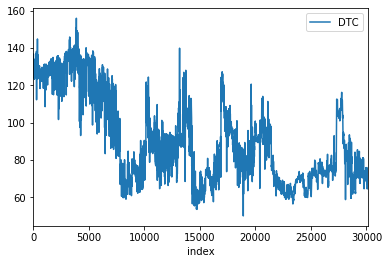

In [96]:
df_original.reset_index().plot(x='index',y ='DTC')

In [120]:
df_original.describe()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS
count,29633.000000,29408.000000,30143.000000,29758.000000,29758.000000,29464.000000,29462.000000,30143.000000,25278.000000
mean,8.654281,0.683437,38.959845,16.953912,14.492077,5.173227,2.393818,90.812841,180.655730
std,1.749145,30.689679,108.504554,349.067878,445.361622,4.781088,0.196276,23.081987,81.141960
min,5.930400,-0.102800,-999.000000,0.054100,0.061600,-0.023200,-1.923800,49.970500,80.580400
25%,8.135600,0.127100,17.248750,0.740450,0.734700,0.054200,2.234800,72.152800,129.446625
50%,8.625000,0.198500,36.821800,1.662750,1.665150,5.042500,2.439600,84.992500,144.593050
75%,9.063000,0.343100,58.346150,3.180350,3.308900,7.949700,2.553000,107.457650,191.475125
max,21.064200,3490.158200,1470.253400,10000.000000,60467.761700,28.106400,3.259700,155.980300,487.438400


In [121]:
# seperate the features and targets
dforigin_data = np.array(df_original)
y_trainwell1 = dforigin_data[:,-2:-1]
x_trainwell1 = dforigin_data[:,:-2]

# standize the matrix for training data
scaler = StandardScaler()
x_trainwell1 = scaler.fit_transform(x_trainwell1)

In [122]:
np.shape(x_trainwell1)

(30143, 7)

In [123]:
# train test split
# please remember to use random_state for all randomization steps, this will ensure we get the same results 
# as yours during the validation phase. 
X_train, X_test, y_train, y_test = train_test_split(x_trainwell1, y_trainwell1, test_size=0.2, random_state=100)

In [124]:
# fitting
params['max_depth'] = 20
params['min_child_weight'] = 2
params['colsample_bytree'] = 0.9
params['subsample'] = 0.9 
params['gamma'] = 0.6
params['n_estimators'] = 180
xgbr = xgb.XGBRegressor(**params)
multi_xgb=xgbr.fit(X_train, y_train)
multi_xgb_pred = multi_xgb.predict(X_test)
R2=format(metrics.r2_score(y_test, multi_xgb_pred),'.4f')   
print('R2:',  R2)

[19:23:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
R2: 0.9838


In [103]:
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
#params={'objective':'reg:squarederror','colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 120, 'subsample': 0.7}
params={'colsample_bytree': 0.9, 'gamma': 0.6, 'learning_rate': 0.05, 'max_depth': 17, 'n_estimators': 180, 'subsample': 0.9}
xgbr = xgb.XGBRegressor(**params)
xgbr.fit(X_train, y_train)

[16:44:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, gamma=0.6,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=17, min_child_weight=1, missing=None, n_estimators=180,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.9, verbosity=1)

In [104]:
cv_results = model_selection.cross_val_score(xgbr, X_train, y_train, cv=5, scoring='r2', verbose=3)
print('Best score: {}'.format(cv_results.max()))
print('Mean score: {}'.format(cv_results.mean()))
print('std score: {}'.format(cv_results.std()))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[16:45:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.982, total=  27.9s
[CV]  ................................................................
[16:46:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   27.8s remaining:    0.0s


[CV] .................................... , score=0.980, total=  30.4s
[CV]  ................................................................
[16:46:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   58.2s remaining:    0.0s


[CV] .................................... , score=0.983, total=  31.5s
[CV]  ................................................................
[16:47:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.982, total=  32.6s
[CV]  ................................................................
[16:47:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.982, total=  33.2s
Best score: 0.9830200966001587
Mean score: 0.9820813441308991
std score: 0.0009129517535199587


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.6min finished


In [106]:
scores = []
params={'colsample_bytree': 0.9, 'gamma': 0.6, 'learning_rate': 0.05, 'max_depth': 17, 'n_estimators': 180, 'subsample': 0.9}
for max_depth in [16,17,18,19,20]:

    params['max_depth'] = max_depth
    xgbr = xgb.XGBRegressor(**params)
    xgbr.fit(X_train, y_train)
    cv_results = model_selection.cross_val_score(xgbr, X_train, y_train, cv=5, scoring='r2', verbose=3)
    best_score = cv_results.max()
    print("max_depth = {}".format(max_depth))
    print('Best score: {}'.format(cv_results.max()))
    print('Mean score: {}'.format(cv_results.mean()))          
    
    scores.append([best_score, params['max_depth'], params['learning_rate'], params['n_estimators'],
                   params['colsample_bytree'], params['subsample'], params['gamma']])

scores = pd.DataFrame(scores, columns=['score', 'max_depth', 'learning_rate','n_estimators',
                                       'colsample_bytree', 'subsample', 'gamma'])
best_max_depth = scores.sort_values(by='score', ascending=False)['max_depth'].values[0]
print('Best max_depth is', best_max_depth)    

[16:56:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[16:57:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.982, total=  31.9s
[CV]  ................................................................
[16:57:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   31.8s remaining:    0.0s


[CV] .................................... , score=0.980, total=  31.5s
[CV]  ................................................................
[16:58:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s


[CV] .................................... , score=0.983, total=  31.5s
[CV]  ................................................................
[16:58:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.982, total=  31.6s
[CV]  ................................................................
[16:59:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.982, total=  31.8s
max_depth = 16
Best score: 0.9828961267073844
Mean score: 0.9818711349373401
[16:59:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[17:00:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.982, total=  33.2s
[CV]  ................................................................
[17:01:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   33.1s remaining:    0.0s


[CV] .................................... , score=0.980, total=  33.2s
[CV]  ................................................................
[17:01:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s


[CV] .................................... , score=0.983, total=  33.3s
[CV]  ................................................................
[17:02:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.982, total=  33.3s
[CV]  ................................................................
[17:02:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.982, total=  33.1s
max_depth = 17
Best score: 0.9830200966001587
Mean score: 0.9820813441308991
[17:03:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[17:04:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.982, total=  33.3s
[CV]  ................................................................
[17:04:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   33.2s remaining:    0.0s


[CV] .................................... , score=0.980, total=  33.6s
[CV]  ................................................................
[17:05:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s


[CV] .................................... , score=0.983, total=  33.6s
[CV]  ................................................................
[17:05:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.982, total=  33.1s
[CV]  ................................................................
[17:06:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.982, total=  33.3s
max_depth = 18
Best score: 0.9830342334768147
Mean score: 0.9820871625554319
[17:06:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[17:07:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.982, total=  31.9s
[CV]  ................................................................
[17:08:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   31.8s remaining:    0.0s


[CV] .................................... , score=0.981, total=  34.6s
[CV]  ................................................................
[17:08:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s


[CV] .................................... , score=0.983, total=  34.9s
[CV]  ................................................................
[17:09:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.982, total=  34.8s
[CV]  ................................................................
[17:09:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.983, total=  34.0s
max_depth = 19
Best score: 0.9829987648282457
Mean score: 0.9821127446102885
[17:10:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[17:11:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.982, total=  27.3s
[CV]  ................................................................
[17:11:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   27.2s remaining:    0.0s


[CV] .................................... , score=0.981, total=  35.5s
[CV]  ................................................................
[17:12:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.0min remaining:    0.0s


[CV] .................................... , score=0.983, total=  36.4s
[CV]  ................................................................
[17:12:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.982, total=  35.3s
[CV]  ................................................................
[17:13:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.983, total=  35.6s
max_depth = 20
Best score: 0.983192144512337
Mean score: 0.9822383836276796
Best max_depth is 20


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.8min finished


In [107]:
%%time
scores = []
for min_child_weight in [1, 2, 3, 4, 5, 6]:

    params['max_depth'] = best_max_depth
    params['min_child_weight'] = min_child_weight
    xgbr = xgb.XGBRegressor(**params)
    xgbr.fit(X_train, y_train)
    cv_results = model_selection.cross_val_score(xgbr, X_train, y_train, cv=5, scoring='r2', verbose=3)
    best_score = cv_results.max()
    print("min_child_weight = {}".format(min_child_weight))
    print('Best score: {}'.format(cv_results.max()))
    print('Mean score: {}'.format(cv_results.mean()))          
    
    scores.append([best_score, params['max_depth'], params['min_child_weight'], params['learning_rate'], params['n_estimators'],
                   params['colsample_bytree'], params['subsample'], params['gamma']])

scores = pd.DataFrame(scores, columns=['score', 'max_depth','min_child_weight', 'learning_rate','n_estimators',
                                       'colsample_bytree', 'subsample', 'gamma'])
best_min_child_weight = scores.sort_values(by='score', ascending=False)['min_child_weight'].values[0]
print('Best min_child_weight is', best_min_child_weight)   

[17:15:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[17:16:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.982, total=  36.8s
[CV]  ................................................................
[17:17:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   36.7s remaining:    0.0s


[CV] .................................... , score=0.981, total=  35.5s
[CV]  ................................................................
[17:17:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s


[CV] .................................... , score=0.983, total=  36.8s
[CV]  ................................................................
[17:18:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.982, total=  37.4s
[CV]  ................................................................
[17:18:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.983, total=  37.2s
min_child_weight = 1
Best score: 0.983192144512337
Mean score: 0.9822383836276796
[17:19:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[17:20:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   33.7s remaining:    0.0s


[CV] .................................... , score=0.983, total=  33.8s
[CV]  ................................................................
[17:20:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.981, total=  35.9s
[CV]  ................................................................
[17:21:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s


[CV] .................................... , score=0.984, total=  36.3s
[CV]  ................................................................
[17:22:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.983, total=  34.3s
[CV]  ................................................................
[17:22:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.983, total=  33.0s
min_child_weight = 2
Best score: 0.9835116604103923
Mean score: 0.9825855879093053
[17:23:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[17:23:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.983, total=  32.2s
[CV]  ................................................................
[17:24:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   32.1s remaining:    0.0s


[CV] .................................... , score=0.981, total=  34.1s
[CV]  ................................................................
[17:24:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s


[CV] .................................... , score=0.983, total=  32.4s
[CV]  ................................................................
[17:25:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.983, total=  32.6s
[CV]  ................................................................
[17:26:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.983, total=  35.4s
min_child_weight = 3
Best score: 0.9834761157732703
Mean score: 0.9825566789397264
[17:26:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[17:27:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.982, total=  34.5s
[CV]  ................................................................
[17:27:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   34.5s remaining:    0.0s


[CV] .................................... , score=0.981, total=  35.9s
[CV]  ................................................................
[17:28:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s


[CV] .................................... , score=0.983, total=  37.0s
[CV]  ................................................................
[17:29:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.983, total=  36.2s
[CV]  ................................................................
[17:29:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.983, total=  35.1s
min_child_weight = 4
Best score: 0.9834022832905491
Mean score: 0.9825591668856722
[17:30:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[17:31:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.982, total=  36.5s
[CV]  ................................................................
[17:31:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   36.4s remaining:    0.0s


[CV] .................................... , score=0.981, total=  35.1s
[CV]  ................................................................
[17:32:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s


[CV] .................................... , score=0.983, total=  36.1s
[CV]  ................................................................
[17:32:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.983, total=  36.5s
[CV]  ................................................................
[17:33:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.983, total=  36.3s
min_child_weight = 5
Best score: 0.9831490541172809
Mean score: 0.9823197259159369
[17:34:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[17:34:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.982, total=  35.9s
[CV]  ................................................................
[17:35:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   35.8s remaining:    0.0s


[CV] .................................... , score=0.981, total=  35.9s
[CV]  ................................................................
[17:36:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s


[CV] .................................... , score=0.983, total=  36.0s
[CV]  ................................................................
[17:36:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.983, total=  35.3s
[CV]  ................................................................
[17:37:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.983, total=  36.0s
min_child_weight = 6
Best score: 0.9830558517021346
Mean score: 0.9821734293610411
Best min_child_weight is 2
Wall time: 22min 1s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.0min finished


In [119]:
# fitting
params['max_depth'] = 20
params['min_child_weight'] = 2
params['colsample_bytree'] = 0.9
params['subsample'] = 0.9 
params['gamma'] = 0.6
params['n_estimators'] = 180
xgbr = xgb.XGBRegressor(**params)
multi_xgb=xgbr.fit(X_train, y_train)
multi_xgb_pred = multi_xgb.predict(X_test)
R2=format(metrics.r2_score(y_test, multi_xgb_pred),'.4f')   
print('R2:',  R2)

[19:21:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
R2: 0.9838


#### Here to explore boxplot of these logs....

In [30]:
df1.columns.tolist()

['CAL', 'CNC', 'GR', 'HRD', 'HRM', 'PE', 'ZDEN', 'DTC', 'DTS']

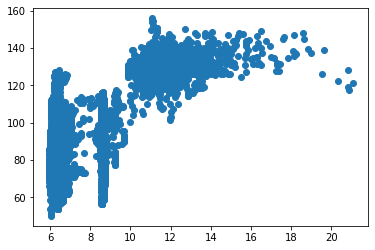

In [31]:
# check if there's any co-linearity between features
# you may check this for all of the features and see if there's any good finding. 
plt.scatter(df1['CAL'], df1['DTC'])

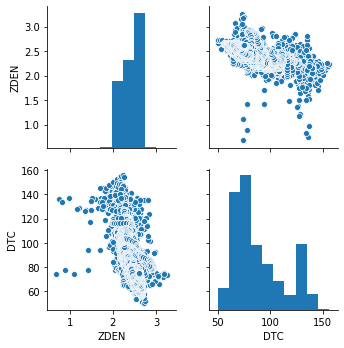

In [32]:
# another library from Seaborn to check the co-linearity
sb.pairplot(df1[['ZDEN', 'DTC']])

## <a>6. Build Machine Learning Models</a>

<a>Top</a>

In [108]:
#remove all rows that contains missing value
df1['DTC'].replace(['-999', -999], np.nan, inplace=True)
df1['DTS'].replace(['-999', -999], np.nan, inplace=True)
df1['CAL'].replace(['-999', -999], np.nan, inplace=True)
df1['CNC'].replace(['-999', -999], np.nan, inplace=True)
df1['PE'].replace(['-999', -999], np.nan, inplace=True)
df1['ZDEN'].replace(['-999', -999], np.nan, inplace=True)
df1['HRD'].replace(['-999', -999], np.nan, inplace=True)
df1['HRM'].replace(['-999', -999], np.nan, inplace=True)

In [109]:
df_no_DTC_null = df1[~df1['DTC'].isnull()]

In [110]:
# seperate the features and targets
df1_data = np.array(df_no_DTC_null)
y_trainwell1 = df1_data[:,-2:-1]
x_trainwell1 = df1_data[:,:-2]

# standize the matrix for training data
scaler = StandardScaler()
x_trainwell1 = scaler.fit_transform(x_trainwell1)

In [34]:
print(y_trainwell1[:5][:])

[[125.9611 306.8676]
 [125.9726 305.8347]
 [125.8528 305.9089]
 [125.7362 305.1737]
 [125.9774 304.4476]]


In [111]:
np.shape(y_trainwell1)

(26089, 1)

In [113]:
# train test split
# please remember to use random_state for all randomization steps, this will ensure we get the same results 
# as yours during the validation phase. 
X_train, X_test, y_train, y_test = train_test_split(x_trainwell1, y_trainwell1, test_size=0.2, random_state=100)

In [116]:
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
#params={'objective':'reg:squarederror','colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 120, 'subsample': 0.7}
params={'colsample_bytree': 0.9, 'gamma': 0.6,'min_child_weight':2, 'learning_rate': 0.05, 'max_depth': 20, 'n_estimators': 180, 'subsample': 0.9}
xgbr = xgb.XGBRegressor(**params)
xgbr.fit(X_train, y_train)


[17:54:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, gamma=0.6,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=20, min_child_weight=2, missing=None, n_estimators=180,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.9, verbosity=1)

In [117]:
cv_results = model_selection.cross_val_score(xgbr, X_train, y_train, cv=5, scoring='r2', verbose=3)
print('Best score: {}'.format(cv_results.max()))
print('Mean score: {}'.format(cv_results.mean()))
print('std score: {}'.format(cv_results.std()))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[17:55:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.982, total=  31.0s
[CV]  ................................................................
[17:56:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   30.9s remaining:    0.0s


[CV] .................................... , score=0.981, total=  21.1s
[CV]  ................................................................
[17:56:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   52.0s remaining:    0.0s


[CV] .................................... , score=0.982, total=  11.8s
[CV]  ................................................................
[17:56:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.982, total=  11.8s
[CV]  ................................................................
[17:57:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.984, total=  11.8s
Best score: 0.984067873550457
Mean score: 0.9819164947666892
std score: 0.001166292114318624


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.5min finished


## XGBoost

In [47]:
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn import model_selection

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, SGDRegressor
# model evaluation
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold


In [48]:

from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
#params={'objective':'reg:squarederror','colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 120, 'subsample': 0.7}
params={'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 120, 'subsample': 0.7}
xgbr = xgb.XGBRegressor(**params)
MultiOutputRegressor(xgbr).fit(X_train, y_train)


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:36:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


MultiOutputRegressor(estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=0.8, gamma=0,
                                            importance_type='gain',
                                            learning_rate=0.05,
                                            max_delta_step=0, max_depth=5,
                                            min_child_weight=1, missing=None,
                                            n_estimators=120, n_jobs=1,
                                            nthread=None,
                                            objective='reg:linear',
                                            random_state=0, reg_alpha=0,
                                            reg_lambda=1, scale_pos_weight=1,
                                            seed=None, silent=None,
                

In [49]:
cv_results = model_selection.cross_val_score(MultiOutputRegressor(xgbr), X_train, y_train, cv=5, scoring='r2', verbose=3)
print('Best score: {}'.format(cv_results.max()))
print('Mean score: {}'.format(cv_results.mean()))
print('std score: {}'.format(cv_results.std()))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[CV]  ................................................................
[13:36:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:36:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.983, total=   2.7s
[CV]  ................................................................
[13:36:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:36:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.982, total=   3.1s
[CV]  ................................................................
[13:36:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.7s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:36:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.982, total=   3.3s
[CV]  ................................................................
[13:37:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:37:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.981, total=   3.2s
[CV]  ................................................................
[13:37:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:37:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.983, total=   2.9s
Best score: 0.9833135031784255
Mean score: 0.9821403958555367
std score: 0.0007664450875617889


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   15.1s finished


In [50]:
scores = []
params={'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 120, 'subsample': 0.7}
for max_depth in [9, 10,11,12,13,14,15,16,17]:

    params['max_depth'] = max_depth
    xgbr = xgb.XGBRegressor(**params)
    MultiOutputRegressor(xgbr).fit(X_train, y_train)
    cv_results = model_selection.cross_val_score(MultiOutputRegressor(xgbr), X_train, y_train, cv=5, scoring='r2', verbose=3)
    best_score = cv_results.max()
    print("max_depth = {}".format(max_depth))
    print('Best score: {}'.format(cv_results.max()))
    print('Mean score: {}'.format(cv_results.mean()))          
    
    scores.append([best_score, params['max_depth'], params['learning_rate'], params['n_estimators'],
                   params['colsample_bytree'], params['subsample'], params['gamma']])

scores = pd.DataFrame(scores, columns=['score', 'max_depth', 'learning_rate','n_estimators',
                                       'colsample_bytree', 'subsample', 'gamma'])
best_max_depth = scores.sort_values(by='score', ascending=False)['max_depth'].values[0]
print('Best max_depth is', best_max_depth)    

C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:37:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:37:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[CV]  ................................................................
[13:37:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:37:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.986, total=   4.6s
[CV]  ................................................................
[13:37:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.5s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:37:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.986, total=   4.6s
[CV]  ................................................................
[13:37:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.1s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:37:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.986, total=   4.3s
[CV]  ................................................................
[13:37:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:37:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.985, total=   4.2s
[CV]  ................................................................
[13:37:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:37:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.987, total=   3.8s
max_depth = 9
Best score: 0.9867641520486305
Mean score: 0.9859525830298349
[13:37:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   21.4s finished
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:37:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[CV]  ................................................................
[13:37:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:37:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.987, total=   5.3s
[CV]  ................................................................
[13:37:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:37:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.987, total=   5.7s
[CV]  ................................................................
[13:37:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.9s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:37:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.986, total=   5.5s
[CV]  ................................................................
[13:38:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:38:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.985, total=   4.7s
[CV]  ................................................................
[13:38:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:38:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.987, total=   4.9s
max_depth = 10
Best score: 0.9870461906870395
Mean score: 0.9863469816669197
[13:38:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   26.1s finished
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:38:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[CV]  ................................................................
[13:38:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:38:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.987, total=   4.8s
[CV]  ................................................................
[13:38:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:38:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.987, total=   4.6s
[CV]  ................................................................
[13:38:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.3s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:38:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.987, total=   4.7s
[CV]  ................................................................
[13:38:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:38:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.985, total=   4.5s
[CV]  ................................................................
[13:38:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:38:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.987, total=   4.9s
max_depth = 11
Best score: 0.9873086387979926
Mean score: 0.986615372014721
[13:38:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   23.4s finished
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:38:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[CV]  ................................................................
[13:38:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:38:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.987, total=   5.1s
[CV]  ................................................................
[13:38:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.0s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:38:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.987, total=   5.1s
[CV]  ................................................................
[13:38:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.1s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:39:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.987, total=   6.3s
[CV]  ................................................................
[13:39:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:39:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.985, total=   6.2s
[CV]  ................................................................
[13:39:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:39:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.988, total=   6.4s
max_depth = 12
Best score: 0.9876583582662547
Mean score: 0.9869276728427521
[13:39:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   28.9s finished
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:39:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[CV]  ................................................................
[13:39:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:39:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.988, total=   5.7s
[CV]  ................................................................
[13:39:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.6s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:39:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.987, total=   6.3s
[CV]  ................................................................
[13:39:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.9s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:39:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.987, total=   6.9s
[CV]  ................................................................
[13:39:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:39:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.985, total=   8.5s
[CV]  ................................................................
[13:39:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:39:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.988, total=   8.4s
max_depth = 13
Best score: 0.9877520496168593
Mean score: 0.987061812805044
[13:40:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   35.7s finished
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:40:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[CV]  ................................................................
[13:40:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:40:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.988, total=   7.1s
[CV]  ................................................................
[13:40:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.0s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:40:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.987, total=   7.2s
[CV]  ................................................................
[13:40:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   14.2s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:40:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.987, total=   6.6s
[CV]  ................................................................
[13:40:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:40:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.986, total=   7.3s
[CV]  ................................................................
[13:40:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:40:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.988, total=   7.2s
max_depth = 14
Best score: 0.9879540707872995
Mean score: 0.9872294305796949
[13:40:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   35.3s finished
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:40:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[CV]  ................................................................
[13:40:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:41:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.988, total=   7.1s
[CV]  ................................................................
[13:41:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.0s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:41:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.988, total=   7.4s
[CV]  ................................................................
[13:41:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   14.5s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:41:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.987, total=   7.2s
[CV]  ................................................................
[13:41:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:41:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.986, total=   7.0s
[CV]  ................................................................
[13:41:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:41:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.988, total=   7.1s
max_depth = 15
Best score: 0.9881233178131712
Mean score: 0.9873416014814094
[13:41:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   35.8s finished
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:41:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[CV]  ................................................................
[13:41:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:41:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.988, total=   9.5s
[CV]  ................................................................
[13:41:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.4s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:41:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.988, total=   9.5s
[CV]  ................................................................
[13:42:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   18.9s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:42:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.988, total=   9.2s
[CV]  ................................................................
[13:42:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:42:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.986, total=   7.8s
[CV]  ................................................................
[13:42:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:42:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.988, total=   7.6s
max_depth = 16
Best score: 0.9881374721036689
Mean score: 0.9874422405221471
[13:42:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   43.4s finished
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:42:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[CV]  ................................................................
[13:42:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:42:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.988, total=   7.9s
[CV]  ................................................................
[13:42:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.8s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:42:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.988, total=   8.0s
[CV]  ................................................................
[13:42:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   15.8s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:42:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.987, total=   7.8s
[CV]  ................................................................
[13:42:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:43:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.986, total=   8.8s
[CV]  ................................................................
[13:43:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:43:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.988, total=   8.1s
max_depth = 17
Best score: 0.9882695944162262
Mean score: 0.987520853668151
Best max_depth is 17


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   40.6s finished


In [108]:
%%time
scores = []
for min_child_weight in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:

    params['max_depth'] = best_max_depth
    params['min_child_weight'] = min_child_weight
    xgbr = xgb.XGBRegressor(**params)
    MultiOutputRegressor(xgbr).fit(X_train, y_train)
    cv_results = model_selection.cross_val_score(MultiOutputRegressor(xgbr), X_train, y_train, cv=5, scoring='r2', verbose=3)
    best_score = cv_results.max()
    print("min_child_weight = {}".format(min_child_weight))
    print('Best score: {}'.format(cv_results.max()))
    print('Mean score: {}'.format(cv_results.mean()))          
    
    scores.append([best_score, params['max_depth'], params['min_child_weight'], params['learning_rate'], params['n_estimators'],
                   params['colsample_bytree'], params['subsample'], params['gamma']])

scores = pd.DataFrame(scores, columns=['score', 'max_depth','min_child_weight', 'learning_rate','n_estimators',
                                       'colsample_bytree', 'subsample', 'gamma'])
best_min_child_weight = scores.sort_values(by='score', ascending=False)['min_child_weight'].values[0]
print('Best min_child_weight is', best_min_child_weight)    

C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[12:00:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:00:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[CV]  ................................................................
[12:00:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:00:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.988, total=   7.6s
[CV]  ................................................................
[12:00:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.5s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[12:00:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.988, total=   7.0s
[CV]  ................................................................
[12:00:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   14.5s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[12:00:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.987, total=   6.8s
[CV]  ................................................................
[12:00:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[12:00:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.986, total=   6.7s
[CV]  ................................................................
[12:00:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[12:01:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.988, total=   6.8s
min_child_weight = 1
Best score: 0.9882695944162262
Mean score: 0.987520853668151
[12:01:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   34.8s finished
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[12:01:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[CV]  ................................................................
[12:01:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:01:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.988, total=   6.6s
[CV]  ................................................................
[12:01:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.5s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[12:01:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.988, total=   7.0s
[CV]  ................................................................
[12:01:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.5s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[12:01:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.988, total=   6.8s
[CV]  ................................................................
[12:01:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[12:01:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.986, total=   7.2s
[CV]  ................................................................
[12:01:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[12:01:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.989, total=   6.8s
min_child_weight = 2
Best score: 0.9885600176485996
Mean score: 0.9876146789437257
[12:01:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   34.2s finished
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[12:01:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[CV]  ................................................................
[12:01:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:02:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.988, total=   6.7s
[CV]  ................................................................
[12:02:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.6s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[12:02:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.987, total=   6.9s
[CV]  ................................................................
[12:02:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.5s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[12:02:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.988, total=   7.5s
[CV]  ................................................................
[12:02:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[12:02:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.986, total=   6.8s
[CV]  ................................................................
[12:02:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[12:02:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.989, total=   7.0s
min_child_weight = 3
Best score: 0.9885200928195992
Mean score: 0.9875754633846627
[12:02:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   34.7s finished
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[12:02:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[CV]  ................................................................
[12:02:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:02:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.988, total=   6.8s
[CV]  ................................................................
[12:02:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.7s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[12:02:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.987, total=   6.5s
[CV]  ................................................................
[12:02:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.2s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[12:02:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.988, total=   6.6s
[CV]  ................................................................
[12:03:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[12:03:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.986, total=   6.7s
[CV]  ................................................................
[12:03:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[12:03:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.988, total=   6.8s
min_child_weight = 4
Best score: 0.9884028330453767
Mean score: 0.9875151430470511
[12:03:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   33.3s finished
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[12:03:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[CV]  ................................................................
[12:03:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:03:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.988, total=   6.7s
[CV]  ................................................................
[12:03:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.6s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[12:03:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.987, total=   6.8s
[CV]  ................................................................
[12:03:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.4s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[12:03:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.988, total=   6.4s
[CV]  ................................................................
[12:03:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[12:03:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.986, total=   6.5s
[CV]  ................................................................
[12:03:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[12:03:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.988, total=   6.4s
min_child_weight = 5
Best score: 0.9882464391557277
Mean score: 0.9872929198511962
[12:03:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   32.6s finished
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[12:03:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[CV]  ................................................................
[12:04:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:04:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.988, total=   6.3s
[CV]  ................................................................
[12:04:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.2s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[12:04:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.987, total=   6.1s
[CV]  ................................................................
[12:04:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   12.3s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[12:04:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.987, total=   6.3s
[CV]  ................................................................
[12:04:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[12:04:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.986, total=   6.1s
[CV]  ................................................................
[12:04:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[12:04:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.988, total=   6.1s
min_child_weight = 6
Best score: 0.9882049173060278
Mean score: 0.9871810840136609
[12:04:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   30.8s finished
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[12:04:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[CV]  ................................................................
[12:04:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:04:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.987, total=   6.3s
[CV]  ................................................................
[12:04:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.2s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[12:04:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.987, total=   7.1s
[CV]  ................................................................
[12:04:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.3s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[12:04:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.987, total=   8.1s
[CV]  ................................................................
[12:05:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[12:05:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.986, total=   8.2s
[CV]  ................................................................
[12:05:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[12:05:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.988, total=   7.6s
min_child_weight = 7
Best score: 0.9881926804173803
Mean score: 0.9870566231302955
[12:05:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   37.2s finished
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[12:05:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[CV]  ................................................................
[12:05:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:05:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.987, total=   6.0s
[CV]  ................................................................
[12:05:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.9s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[12:05:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.987, total=   6.1s
[CV]  ................................................................
[12:05:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   12.0s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[12:05:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.987, total=   6.3s
[CV]  ................................................................
[12:05:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[12:05:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.985, total=   6.1s
[CV]  ................................................................
[12:05:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[12:05:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.988, total=   6.3s
min_child_weight = 8
Best score: 0.9881041805174314
Mean score: 0.9869556347742533
[12:05:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   30.6s finished
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[12:06:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[CV]  ................................................................
[12:06:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:06:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.987, total=   6.7s
[CV]  ................................................................
[12:06:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.6s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[12:06:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.987, total=   7.6s
[CV]  ................................................................
[12:06:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   14.3s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[12:06:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.987, total=   7.6s
[CV]  ................................................................
[12:06:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[12:06:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.985, total=   7.3s
[CV]  ................................................................
[12:06:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[12:06:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.988, total=   7.1s
min_child_weight = 9
Best score: 0.987937832365722
Mean score: 0.9868810860606642
[12:06:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   36.3s finished
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[12:06:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[CV]  ................................................................
[12:06:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:06:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.987, total=   7.0s
[CV]  ................................................................
[12:06:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.9s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[12:07:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.987, total=   7.2s
[CV]  ................................................................
[12:07:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   14.1s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[12:07:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.987, total=   7.0s
[CV]  ................................................................
[12:07:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[12:07:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.985, total=   7.3s
[CV]  ................................................................
[12:07:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[12:07:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.988, total=   7.0s
min_child_weight = 10
Best score: 0.9877870968519116
Mean score: 0.9867205621091382
Best min_child_weight is 2
Wall time: 7min 3s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   35.4s finished


In [110]:
%%time
scores = []
for colsample_bytree in [0.1, 0.3, 0.5, 0.7, 0.9]:

    params['max_depth'] = best_max_depth
    params['min_child_weight'] = best_min_child_weight
    params['colsample_bytree'] = colsample_bytree
    xgbr = xgb.XGBRegressor(**params)
    MultiOutputRegressor(xgbr).fit(X_train, y_train)
    cv_results = model_selection.cross_val_score(MultiOutputRegressor(xgbr), X_train, y_train, cv=5, scoring='r2', verbose=3)
    best_score = cv_results.max()
    print("colsample_bytree = {}".format(colsample_bytree))
    print('Best score: {}'.format(cv_results.max()))
    print('Mean score: {}'.format(cv_results.mean()))          
    
    scores.append([best_score, params['max_depth'], params['min_child_weight'], params['learning_rate'], params['n_estimators'],
                   params['colsample_bytree'], params['subsample'], params['gamma']])

scores = pd.DataFrame(scores, columns=['score', 'max_depth','min_child_weight', 'learning_rate','n_estimators',
                                       'colsample_bytree', 'subsample', 'gamma'])
best_colsample_bytree = scores.sort_values(by='score', ascending=False)['colsample_bytree'].values[0]
print('Best colsample_bytree is', best_colsample_bytree)   

C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:00:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:00:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[CV]  ................................................................
[13:00:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:00:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.923, total=   5.9s
[CV]  ................................................................
[13:00:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.8s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:00:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.921, total=   6.7s
[CV]  ................................................................
[13:00:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   12.5s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:00:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.920, total=   6.4s
[CV]  ................................................................
[13:00:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:00:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.929, total=   6.1s
[CV]  ................................................................
[13:00:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:00:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.924, total=   6.3s
colsample_bytree = 0.1
Best score: 0.9290416826882739
Mean score: 0.9234766055413619
[13:00:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   31.4s finished
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:01:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[CV]  ................................................................
[13:01:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:01:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.977, total=   9.5s
[CV]  ................................................................
[13:01:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.4s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:01:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.975, total=   9.5s
[CV]  ................................................................
[13:01:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   18.9s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:01:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.976, total=   9.7s
[CV]  ................................................................
[13:01:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:01:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.977, total=   9.6s
[CV]  ................................................................
[13:01:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:01:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.978, total=   9.6s
colsample_bytree = 0.3
Best score: 0.9780251260439281
Mean score: 0.9766454827150088
[13:01:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   47.9s finished
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:02:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[CV]  ................................................................
[13:02:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:02:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.985, total=  12.1s
[CV]  ................................................................
[13:02:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.0s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:02:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.984, total=  12.1s
[CV]  ................................................................
[13:02:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   24.1s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:02:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.985, total=  11.9s
[CV]  ................................................................
[13:02:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:02:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.984, total=  11.9s
[CV]  ................................................................
[13:02:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:03:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.986, total=  11.8s
colsample_bytree = 0.5
Best score: 0.9855135373902262
Mean score: 0.9846618506238816
[13:03:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   59.6s finished
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:03:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[CV]  ................................................................
[13:03:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:03:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.987, total=  11.2s
[CV]  ................................................................
[13:03:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.1s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:03:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.987, total=   9.5s
[CV]  ................................................................
[13:03:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   20.6s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:03:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.987, total=  10.6s
[CV]  ................................................................
[13:03:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:04:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.986, total=  12.9s
[CV]  ................................................................
[13:04:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:04:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.988, total=  13.2s
colsample_bytree = 0.7
Best score: 0.9877089039877651
Mean score: 0.9869003849030433
[13:04:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   57.3s finished
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:04:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[CV]  ................................................................
[13:04:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:04:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.989, total=  16.5s
[CV]  ................................................................
[13:05:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.4s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:05:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.988, total=  17.2s
[CV]  ................................................................
[13:05:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   33.6s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:05:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.988, total=  17.2s
[CV]  ................................................................
[13:05:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:05:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.986, total=  17.4s
[CV]  ................................................................
[13:05:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:06:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.989, total=  18.4s
colsample_bytree = 0.9
Best score: 0.9888939919221147
Mean score: 0.9880119938828141
Best colsample_bytree is 0.9
Wall time: 5min 56s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.4min finished


In [111]:
%%time
scores = []
for subsample in [0.1, 0.3, 0.5, 0.7, 0.9]:

    params['max_depth'] = best_max_depth
    params['min_child_weight'] = best_min_child_weight
    params['colsample_bytree'] = best_colsample_bytree
    params['subsample'] = subsample 
    xgbr = xgb.XGBRegressor(**params)
    MultiOutputRegressor(xgbr).fit(X_train, y_train)
    cv_results = model_selection.cross_val_score(MultiOutputRegressor(xgbr), X_train, y_train, cv=5, scoring='r2', verbose=3)
    best_score = cv_results.max()
    print("subsumple = {}".format(subsample))
    print('Best score: {}'.format(cv_results.max()))
    print('Mean score: {}'.format(cv_results.mean()))          
    
    scores.append([best_score, params['max_depth'], params['min_child_weight'], params['learning_rate'], params['n_estimators'],
                   params['colsample_bytree'], params['subsample'], params['gamma']])

scores = pd.DataFrame(scores, columns=['score', 'max_depth','min_child_weight', 'learning_rate','n_estimators',
                                       'colsample_bytree', 'subsample', 'gamma'])
best_subsample = scores.sort_values(by='score', ascending=False)['subsample'].values[0]
print('Best subsample is', best_subsample)   

C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:11:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:11:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[CV]  ................................................................
[13:11:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:11:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.984, total=   7.2s
[CV]  ................................................................
[13:11:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.1s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:11:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.983, total=   8.3s
[CV]  ................................................................
[13:11:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   15.4s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:11:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.983, total=   8.3s
[CV]  ................................................................
[13:11:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:11:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.982, total=   8.7s
[CV]  ................................................................
[13:11:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:11:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.984, total=   8.5s
subsumple = 0.1
Best score: 0.9840764318773418
Mean score: 0.9830812135426079
[13:11:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   40.9s finished
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:12:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[CV]  ................................................................
[13:12:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:12:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.987, total=  13.7s
[CV]  ................................................................
[13:12:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.6s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:12:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.986, total=  13.6s
[CV]  ................................................................
[13:12:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   27.2s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:12:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.986, total=  13.7s
[CV]  ................................................................
[13:12:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:13:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.985, total=  13.6s
[CV]  ................................................................
[13:13:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:13:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.987, total=  12.7s
subsumple = 0.3
Best score: 0.9874214713597615
Mean score: 0.986399898926676
[13:13:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.1min finished
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:13:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[CV]  ................................................................
[13:13:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:13:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.988, total=  18.0s
[CV]  ................................................................
[13:14:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.9s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:14:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.987, total=  17.6s
[CV]  ................................................................
[13:14:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   35.5s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:14:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.988, total=  17.6s
[CV]  ................................................................
[13:14:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:14:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.986, total=  17.2s
[CV]  ................................................................
[13:14:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:15:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.989, total=  17.3s
subsumple = 0.5
Best score: 0.9885058481501738
Mean score: 0.9875141220709297
[13:15:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.5min finished
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:15:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[CV]  ................................................................
[13:15:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:15:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.989, total=  18.5s
[CV]  ................................................................
[13:15:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.4s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:16:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.988, total=  18.5s
[CV]  ................................................................
[13:16:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   36.9s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:16:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.988, total=  18.7s
[CV]  ................................................................
[13:16:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:16:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.986, total=  19.3s
[CV]  ................................................................
[13:16:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:16:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.989, total=  16.3s
subsumple = 0.7
Best score: 0.9888939919221147
Mean score: 0.9880119938828141
[13:17:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.5min finished
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:17:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[CV]  ................................................................
[13:17:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:17:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.989, total=  18.7s
[CV]  ................................................................
[13:17:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.6s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:17:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.988, total=  18.8s
[CV]  ................................................................
[13:18:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   37.5s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:18:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.988, total=  18.6s
[CV]  ................................................................
[13:18:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:18:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.987, total=  18.3s
[CV]  ................................................................
[13:18:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:18:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.989, total=  18.9s
subsumple = 0.9
Best score: 0.9890708403566295
Mean score: 0.9883238416909215
Best subsample is 0.9
Wall time: 7min 56s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.6min finished


In [113]:
%%time
scores = []
for gamma in [0, 0.3, 0.4, 0.5, 0.6, 0.7,1]:

    params['max_depth'] = best_max_depth
    params['min_child_weight'] = best_min_child_weight
    params['colsample_bytree'] = best_colsample_bytree
    params['subsample'] = best_subsample 
    params['gamma'] = gamma
    xgbr = xgb.XGBRegressor(**params)
    MultiOutputRegressor(xgbr).fit(X_train, y_train)
    cv_results = model_selection.cross_val_score(MultiOutputRegressor(xgbr), X_train, y_train, cv=5, scoring='r2', verbose=3)
    best_score = cv_results.max()
    print("gamma = {}".format(gamma))
    print('Best score: {}'.format(cv_results.max()))
    print('Mean score: {}'.format(cv_results.mean()))          
    
    scores.append([best_score, params['max_depth'], params['min_child_weight'], params['learning_rate'], params['n_estimators'],
                   params['colsample_bytree'], params['subsample'], params['gamma']])

scores = pd.DataFrame(scores, columns=['score', 'max_depth','min_child_weight', 'learning_rate','n_estimators',
                                       'colsample_bytree', 'subsample', 'gamma'])
best_gamma = scores.sort_values(by='score', ascending=False)['gamma'].values[0]
print('Best subsample is', best_gamma)   

C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:26:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:26:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[CV]  ................................................................
[13:26:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:26:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.989, total=  18.6s
[CV]  ................................................................
[13:27:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.5s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:27:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.988, total=  18.6s
[CV]  ................................................................
[13:27:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   37.1s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:27:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.988, total=  17.8s
[CV]  ................................................................
[13:27:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:27:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.987, total=  18.2s
[CV]  ................................................................
[13:28:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:28:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.989, total=  18.5s
gamma = 0
Best score: 0.9890708403566295
Mean score: 0.9883238416909215
[13:28:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.5min finished
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:28:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[CV]  ................................................................
[13:28:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:28:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.989, total=  18.3s
[CV]  ................................................................
[13:29:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.2s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:29:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.988, total=  17.5s
[CV]  ................................................................
[13:29:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   35.8s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:29:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.988, total=  17.9s
[CV]  ................................................................
[13:29:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:29:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.987, total=  16.0s
[CV]  ................................................................
[13:29:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:29:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.989, total=  14.2s
gamma = 0.3
Best score: 0.9891096865991356
Mean score: 0.9883382277269938
[13:30:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.4min finished
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:30:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  ................................................................
[13:30:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:30:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.989, total=  17.8s
[CV]  ................................................................
[13:30:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.7s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:30:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.988, total=  18.6s
[CV]  ................................................................
[13:31:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   36.3s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:31:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.988, total=  18.9s
[CV]  ................................................................
[13:31:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:31:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.987, total=   9.7s
[CV]  ................................................................
[13:31:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:31:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.989, total=   7.2s
gamma = 0.4
Best score: 0.9891070234087929
Mean score: 0.9883009052804633
[13:31:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.2min finished
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:31:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[CV]  ................................................................
[13:31:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:31:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.989, total=   7.0s
[CV]  ................................................................
[13:31:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.9s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:32:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.988, total=   7.0s
[CV]  ................................................................
[13:32:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.9s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:32:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.988, total=   7.3s
[CV]  ................................................................
[13:32:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:32:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.987, total=   7.1s
[CV]  ................................................................
[13:32:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:32:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.989, total=   7.3s
gamma = 0.5
Best score: 0.9891044551534145
Mean score: 0.9883558956139369
[13:32:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   35.6s finished
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:32:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[CV]  ................................................................
[13:32:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:32:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.989, total=   7.4s
[CV]  ................................................................
[13:32:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.3s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:32:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.988, total=   7.2s
[CV]  ................................................................
[13:32:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   14.5s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:32:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.988, total=   7.3s
[CV]  ................................................................
[13:32:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:33:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.987, total=   7.3s
[CV]  ................................................................
[13:33:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:33:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.989, total=   7.5s
gamma = 0.6
Best score: 0.9892309458971966
Mean score: 0.9883603598597943
[13:33:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   36.6s finished
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:33:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[CV]  ................................................................
[13:33:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:33:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.989, total=   7.9s
[CV]  ................................................................
[13:33:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.8s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:33:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.988, total=   7.6s
[CV]  ................................................................
[13:33:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   15.4s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:33:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.988, total=   7.8s
[CV]  ................................................................
[13:33:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:33:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.987, total=   7.7s
[CV]  ................................................................
[13:33:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:33:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.989, total=   7.8s
gamma = 0.7
Best score: 0.98914364336334
Mean score: 0.9883247846176548
[13:33:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   38.7s finished
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:34:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[CV]  ................................................................
[13:34:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:34:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.989, total=   8.4s
[CV]  ................................................................
[13:34:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.3s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:34:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.988, total=   7.6s
[CV]  ................................................................
[13:34:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   15.9s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:34:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.988, total=   7.9s
[CV]  ................................................................
[13:34:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:34:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.987, total=   8.0s
[CV]  ................................................................
[13:34:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[13:34:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.989, total=   9.0s
gamma = 1
Best score: 0.9891008852487222
Mean score: 0.9883265257303874
Best subsample is 0.6
Wall time: 8min 25s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   40.8s finished


In [114]:
%%time
scores = []
for estimator in [80, 100, 110, 120, 130, 140, 160, 180]:

    params['max_depth'] = best_max_depth
    params['min_child_weight'] = best_min_child_weight
    params['colsample_bytree'] = best_colsample_bytree
    params['subsample'] = best_subsample 
    params['gamma'] = best_gamma
    params['n_estimators'] = estimator
    xgbr = xgb.XGBRegressor(**params)
    MultiOutputRegressor(xgbr).fit(X_train, y_train)
    cv_results = model_selection.cross_val_score(MultiOutputRegressor(xgbr), X_train, y_train, cv=5, scoring='r2', verbose=3)
    best_score = cv_results.max()
    print("n_estimators = {}".format(estimator))
    print('Best score: {}'.format(cv_results.max()))
    print('Mean score: {}'.format(cv_results.mean()))          
    
    scores.append([best_score, params['max_depth'], params['min_child_weight'], params['learning_rate'], params['n_estimators'],
                   params['colsample_bytree'], params['subsample'], params['gamma']])

scores = pd.DataFrame(scores, columns=['score', 'max_depth','min_child_weight', 'learning_rate','n_estimators',
                                       'colsample_bytree', 'subsample', 'gamma'])
best_n_estimators = scores.sort_values(by='score', ascending=False)['n_estimators'].values[0]
print('Best n_estimator is', best_n_estimators)   

C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[15:36:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:36:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[CV]  ................................................................
[15:36:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:36:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.985, total=  11.0s
[CV]  ................................................................
[15:36:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.9s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[15:36:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.984, total=  10.8s
[CV]  ................................................................
[15:36:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   21.7s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[15:37:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.983, total=  10.7s
[CV]  ................................................................
[15:37:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[15:37:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.982, total=  10.7s
[CV]  ................................................................
[15:37:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[15:37:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.985, total=   9.5s
n_estimators = 80
Best score: 0.984736482699893
Mean score: 0.983749988885925
[15:37:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   52.6s finished
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[15:37:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[CV]  ................................................................
[15:37:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:37:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.988, total=  14.7s
[CV]  ................................................................
[15:37:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.6s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[15:38:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.988, total=  14.5s
[CV]  ................................................................
[15:38:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   29.0s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[15:38:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.987, total=  14.5s
[CV]  ................................................................
[15:38:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[15:38:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.986, total=  14.5s
[CV]  ................................................................
[15:38:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[15:38:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.988, total=  14.8s
n_estimators = 100
Best score: 0.9884222215324002
Mean score: 0.9875357338075276
[15:38:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.2min finished
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[15:39:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[CV]  ................................................................
[15:39:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:39:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.989, total=  15.6s
[CV]  ................................................................
[15:39:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.5s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[15:39:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.988, total=  14.1s
[CV]  ................................................................
[15:39:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   29.6s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[15:39:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.988, total=  11.4s
[CV]  ................................................................
[15:39:58] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[15:40:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.987, total=  15.5s
[CV]  ................................................................
[15:40:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[15:40:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.989, total=  16.0s
n_estimators = 110
Best score: 0.9889534949953093
Mean score: 0.9880796828587595
[15:40:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.2min finished
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[15:40:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[CV]  ................................................................
[15:40:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:41:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.989, total=  17.5s
[CV]  ................................................................
[15:41:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.4s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[15:41:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.988, total=  17.6s
[CV]  ................................................................
[15:41:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   34.9s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[15:41:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.988, total=  17.6s
[CV]  ................................................................
[15:41:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[15:41:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.987, total=  18.4s
[CV]  ................................................................
[15:42:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[15:42:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.989, total=  17.5s
n_estimators = 120
Best score: 0.9892309458971966
Mean score: 0.9883603598597943
[15:42:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.5min finished
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[15:42:33] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[CV]  ................................................................
[15:42:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:42:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.989, total=  17.5s
[CV]  ................................................................
[15:43:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.4s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[15:43:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.989, total=  16.4s
[CV]  ................................................................
[15:43:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   33.8s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[15:43:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.989, total=  18.6s
[CV]  ................................................................
[15:43:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[15:43:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.987, total=  18.5s
[CV]  ................................................................
[15:43:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[15:44:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.989, total=  20.5s
n_estimators = 130
Best score: 0.9893676298825491
Mean score: 0.9885114559276171
[15:44:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.5min finished
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[15:44:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[CV]  ................................................................
[15:44:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:44:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.989, total=  20.9s
[CV]  ................................................................
[15:45:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.8s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[15:45:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.989, total=  21.4s
[CV]  ................................................................
[15:45:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   42.1s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[15:45:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.989, total=  21.9s
[CV]  ................................................................
[15:45:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[15:45:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.987, total=  20.9s
[CV]  ................................................................
[15:46:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[15:46:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.989, total=  16.5s
n_estimators = 140
Best score: 0.9894478507852507
Mean score: 0.988605213936666
[15:46:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.7min finished
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[15:46:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[CV]  ................................................................
[15:46:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:47:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.989, total=  24.9s
[CV]  ................................................................
[15:47:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.8s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[15:47:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.989, total=  24.7s
[CV]  ................................................................
[15:47:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   49.5s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[15:47:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.989, total=  23.9s
[CV]  ................................................................
[15:48:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[15:48:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.987, total=  24.6s
[CV]  ................................................................
[15:48:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[15:48:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.990, total=  24.0s
n_estimators = 160
Best score: 0.9895355975578427
Mean score: 0.988703706076897
[15:48:56] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.0min finished
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[15:49:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[CV]  ................................................................
[15:49:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:49:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.989, total=  29.2s
[CV]  ................................................................
[15:50:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   29.1s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[15:50:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.989, total=  28.6s
[CV]  ................................................................
[15:50:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   57.6s remaining:    0.0s
C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[15:50:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.989, total=  28.1s
[CV]  ................................................................
[15:50:57] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[15:51:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.987, total=  28.6s
[CV]  ................................................................
[15:51:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[15:51:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV] .................................... , score=0.990, total=  28.9s
n_estimators = 180
Best score: 0.989575759310432
Mean score: 0.9887551084018618
Best n_estimator is 180
Wall time: 15min 34s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.4min finished


In [116]:
print(best_max_depth, best_min_child_weight,
      best_colsample_bytree, best_subsample, best_gamma, best_n_estimators)

scores.sort_values(by='score',ascending=False)

17 2 0.9 0.9 0.6 180


,score,max_depth,min_child_weight,learning_rate,n_estimators,colsample_bytree,subsample,gamma
7,0.989576,17,2,0.05,180,0.9,0.9,0.6
6,0.989536,17,2,0.05,160,0.9,0.9,0.6
5,0.989448,17,2,0.05,140,0.9,0.9,0.6
4,0.989368,17,2,0.05,130,0.9,0.9,0.6
3,0.989231,17,2,0.05,120,0.9,0.9,0.6
2,0.988953,17,2,0.05,110,0.9,0.9,0.6
1,0.988422,17,2,0.05,100,0.9,0.9,0.6
0,0.984736,17,2,0.05,80,0.9,0.9,0.6


C:\Users\bohu8515\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[16:33:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
R2: 0.9901
Root Mean Square Error is: 5.43997


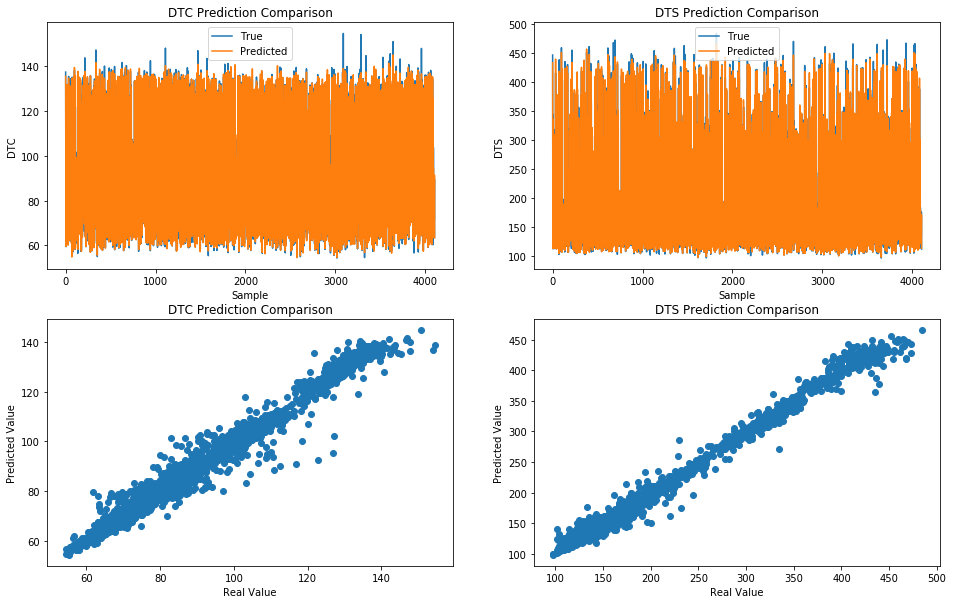

In [121]:
# fitting
params['max_depth'] = best_max_depth
params['min_child_weight'] = best_min_child_weight
params['colsample_bytree'] = best_colsample_bytree
params['subsample'] = best_subsample 
params['gamma'] = best_gamma
params['n_estimators'] = best_n_estimators
xgbr = xgb.XGBRegressor(**params)
multi_xgb=MultiOutputRegressor(xgbr).fit(X_train, y_train)
multi_xgb_pred = multi_xgb.predict(X_test)
R2=format(metrics.r2_score(y_test, multi_xgb_pred),'.4f')   
print('R2:',  R2)
result_plot(multi_xgb_pred,y_test)

## <a>7. Prediction</a>

<a>Top</a>

In [18]:
# load test data from well 2
df2 = pd.read_csv('test2_19.csv')
# Remove missing 
for col in df2.columns.tolist():
    df2[col][df2[col]==-999] = np.nan
df2.dropna(axis=0, inplace=True)
df2_data = np.array(df2)
x_trainwell2 = df2_data
x_trainwell2 = scaler.transform(x_trainwell2)
#print(y_trainwell2.head())
print(x_trainwell2[:5][:])

[[ 0.08203273  0.02536682  0.09657322 -0.51553228 -0.01196495  0.68453048
  -0.46851864]
 [ 0.08203273  0.02921998  0.12994323 -0.51792726 -0.01198555  0.68016548
  -0.46906897]
 [ 0.08203273  0.03130983  0.16488049 -0.53506725 -0.01214533  0.67253243
  -0.49273318]
 [ 0.07358141  0.03013429  0.13577067 -0.54300242 -0.01226511  0.66003161
  -0.54391391]
 [ 0.08203273  0.02468108  0.05789392 -0.55235151 -0.01236761  0.640949
  -0.61930917]]


In [19]:
# run the prediction
well2_predict = RF_best.predict(x_trainwell2)
well2_predict[:5, :]

array([[100.838968, 210.14813 ],
       [101.221902, 211.240249],
       [102.780163, 213.368357],
       [102.310366, 213.662395],
       [103.985616, 216.006953]])

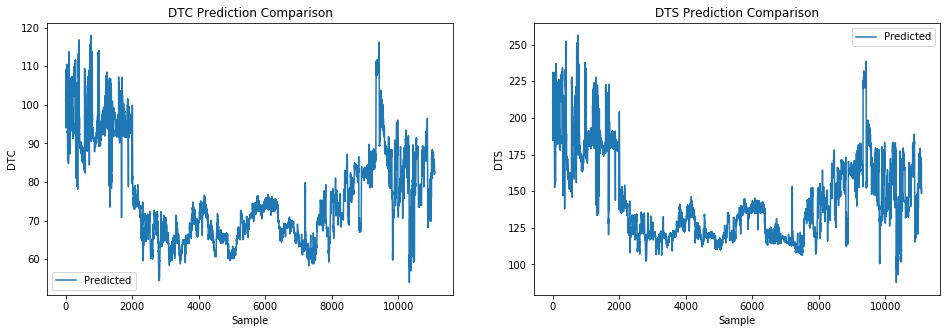

In [20]:
# plot the prediction results 
plt.subplots(nrows=1, ncols=2, figsize=(16,5))
plt.subplot(1, 2, 1)
plt.plot(well2_predict[:, 0])
plt.legend(['Predicted'])
plt.xlabel('Sample')
plt.ylabel('DTC')
plt.title('DTC Prediction Comparison')

plt.subplot(1, 2, 2)
plt.plot(well2_predict[:, 1])
plt.legend(['Predicted'])
plt.xlabel('Sample')
plt.ylabel('DTS')
plt.title('DTS Prediction Comparison')
plt.show()

In [21]:
output_result = pd.DataFrame({'DTC':well2_predict[:,0], 'DTS':well2_predict[:,1]})
output_result.head()

,DTC,DTS
0,100.838968,210.148130
1,101.221902,211.240249
2,102.780163,213.368357
3,102.310366,213.662395
4,103.985616,216.006953


In [22]:
#output_result.to_csv(path_or_buf='./sample_submission.csv', index=False)
output_result.to_csv(path_or_buf='./sample_submission2_19.csv', index=False)

## <a>8. Summary</a>

<a>Top</a>

Put your ideas, findings, insights, suggestions, and references here